In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
from datetime import *
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals import joblib
from fbprophet import Prophet

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
#导入训练数据
train_data = pd.read_csv('prophet_fusai_B_stacking_train_feature_set.csv')

#根据prophet定义训练集
df_allBrand = train_data
df_allBrand['guess_date'] = df_allBrand['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_allBrand.rename(columns = {'guess_date':'ds', 'cnt':'y', 'brand':'brand'}, inplace=True)

print(df_allBrand.head(10))

   brand   y  date  day_of_week         ds  week  date_year  date_month  \
0      1  31     1            2 2013-01-01     0       2013           1   
1      6   6     1            2 2013-01-01     0       2013           1   
2      9  15     1            2 2013-01-01     0       2013           1   
3      4  20     2            3 2013-01-02     0       2013           1   
4      6   6     2            3 2013-01-02     0       2013           1   
5      7  30     2            3 2013-01-02     0       2013           1   
6     10  48     2            3 2013-01-02     0       2013           1   
7      4  16     3            4 2013-01-03     0       2013           1   
8      6   4     3            4 2013-01-03     0       2013           1   
9      8  23     3            4 2013-01-03     0       2013           1   

   date_property guess_date_str    ...     brand_1 brand_2  brand_3  brand_4  \
0              2     2013-01-01    ...           1       0        0        0   
1             

In [5]:
#为模型添加节假日特征
#元旦
NewYearDay = pd.DataFrame({
  'holiday': 'NewYearDay',
  'ds': pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03',
                        '2014-01-01', 
                        '2015-01-01', '2015-01-02', '2015-01-03',
                        '2016-01-01', '2016-01-02', '2016-01-03',
                        '2016-12-31', '2017-01-02', '2017-01-01'])
})

#春节
ChineseNewYearDay = pd.DataFrame({
  'holiday': 'ChineseNewYearDay',
  'ds': pd.to_datetime(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
                        '2014-01-31', '2014-02-01', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-05-02', 
                        '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24',
                        '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
                       '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02'])
})

#国庆节
NationalDay = pd.DataFrame({
  'holiday': 'NationalDay',
  'ds': pd.to_datetime(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05', '2013-10-06', '2013-10-07',
                        '2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07', 
                        '2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
                        '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07',
                       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07', 
                       '2017-10-08'])
})

#劳动节
MayDay = pd.DataFrame({
  'holiday': 'MayDay',
  'ds': pd.to_datetime(['2013-04-29', '2013-04-30', '2013-05-01',
                        '2014-05-01', '2014-05-02', '2014-05-03',  
                        '2015-05-01', '2015-05-02', '2015-05-03',
                        '2016-05-01', '2016-05-02', '2016-04-30',
                       '2017-04-29', '2017-04-30', '2017-05-01'])
})

#清明节
ChingMingDay = pd.DataFrame({
  'holiday': 'ChingMingDay',
  'ds': pd.to_datetime(['2013-04-04', '2013-04-05', '2013-04-06',
                        '2014-04-05', '2014-04-06', '2014-04-07',  
                        '2015-04-04', '2015-04-05', '2015-04-06',
                        '2016-04-02', '2016-04-03', '2016-04-04',
                       '2017-04-02', '2017-04-03', '2017-04-04'])
})

#端午节
DragonBoatDay = pd.DataFrame({
  'holiday': 'DragonBoatDay',
  'ds': pd.to_datetime(['2013-06-10', '2013-06-11', '2013-06-12',
                        '2014-05-31', '2014-06-01', '2014-06-02',  
                        '2015-06-20', '2015-06-21', '2015-06-22',
                        '2016-06-09', '2016-06-10', '2016-06-11',
                       '2017-05-28', '2017-05-29', '2017-05-30'])
})

#中秋节
MidAutumnDay = pd.DataFrame({
  'holiday': 'MidAutumnDay',
  'ds': pd.to_datetime(['2013-09-19', '2013-09-20', '2013-09-21',
                        '2014-09-06', '2014-09-07', '2014-09-08',  
                        '2015-09-26', '2015-09-27',
                        '2015-09-03', '2015-09-04', '2015-09-05',
                        '2016-09-15', '2016-09-16', '2016-09-17'])
})

holidays = pd.concat((NewYearDay, ChineseNewYearDay, NationalDay, MayDay, ChingMingDay, DragonBoatDay, MidAutumnDay))

In [6]:
#导入预测数据集
test_data = pd.read_csv('prophet_fusai_B_fullfilling_test_feature_set.csv')
test_data['guess_date'] = test_data['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
test_data.rename(columns = {'guess_date':'ds'}, inplace=True)

In [8]:
#定义根据date_property是否为0，预测数据的函数
def predictByProphet(df_train, df_test, holidays, cap, floor, none_value, changepoint_prior_scale,
                            interval_width, regressor_set, changepoints):
    #处理训练集相关数据
    df_train['y'] = df_train['y'].map(lambda x: None if x > none_value else x)
    #定义最大值和最小值
    df_train['cap'] = cap
    df_train['floor'] = floor
    
    #定义prophet模型和预测集
    m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints,
                changepoint_prior_scale = changepoint_prior_scale, interval_width = interval_width)
    m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)
    
    #添加额外特征
    for regressor_future in regressor_set:
        m.add_regressor(regressor_future)
        
    m.fit(df_train)
    
    #处理测试集相关数据
    test_data = pd.concat([df_train.drop('y', 1), df_test])
    test_data['cap'] = cap
    test_data['floor'] = floor
    
    forcast = m.predict(test_data)
    return m, forcast

df_brand9_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand9_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand9_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property != 0)]
m_brand9_restday, forcast_brand9_restday = predictByProphet(df_brand9_restday, test_data_brand9_restday, holidays, 500, -500, 500, 0.5,
                0.95, df_brand9_restday_regressor_set, brand9_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
229 2016-09-03  165.041934   38.205996  299.221385
230 2016-09-10  157.841105   24.860007  290.358693
231 2016-09-15   49.412251  -79.283294  180.199016
232 2016-09-24  118.905712  -12.397600  249.677720
233 2016-10-04   65.488817  -65.576971  198.021115
234 2016-10-05   68.772426  -57.997813  199.413492
235 2016-10-07   49.930147  -74.332485  183.311295
236 2016-10-15  143.249651   29.724136  278.619089
237 2016-10-22  160.402202   30.163228  282.474794
238 2016-10-29  161.262958   36.378514  295.576830
239 2016-10-30   69.340526  -65.183542  201.439627
240 2016-11-05  146.365600   19.679516  272.535155
241 2016-11-12  126.913998   -3.698424  256.887270
242 2016-11-19  114.911865  -17.731595  245.864994
243 2016-11-20   23.623068  -97.966858  146.099980
244 2016-11-26  115.340430  -11.889626  249.900655
245 2016-12-03  126.553457    0.402675  251.142388
246 2016-12-10  145.180728   17.238072  273.630589
247 2016-12-17  168.072737   41

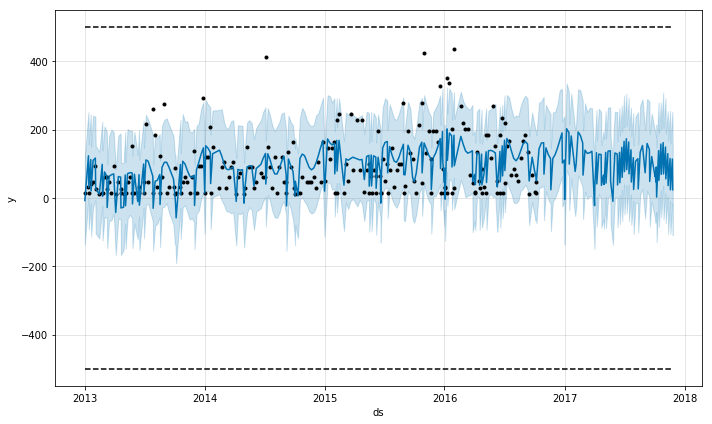

In [9]:
print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_restday.ds < '2016-01-10') & (forcast_brand9_restday.ds > '2016-01-01')])
m_brand9_restday.plot(forcast_brand9_restday)

In [10]:
df_brand9_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & (train_data.date_property == 0)]
df_brand9_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand9_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property == 0)]
m_brand9_workday, forcast_brand9_workday = predictByProphet(df_brand9_workday, test_data_brand9_workday, holidays, 1400, -100, 1800, 0.5,
                0.95, df_brand9_workday_regressor_set, brand9_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds         yhat  yhat_lower   yhat_upper
1124 2017-07-06   640.637073  225.144694  1079.656785
1125 2017-07-07   739.539984  273.963421  1183.761126
1126 2017-07-10   763.388552  328.139333  1209.762360
1127 2017-07-11   796.861726  391.139312  1286.574279
1128 2017-07-12   728.024255  290.943441  1170.435544
1129 2017-07-13   582.361746  152.522106   991.476627
1130 2017-07-14   682.921549  199.398501  1117.507502
1131 2017-07-17   717.474177  275.595619  1132.592476
1132 2017-07-18   756.018397  311.191395  1168.306350
1133 2017-07-19   692.756990  211.950884  1139.956612
1134 2017-07-20   553.010828  130.166815   995.880172
1135 2017-07-21   659.657632  226.042663  1093.724543
1136 2017-07-24   711.823972  304.273440  1133.498054
1137 2017-07-25   755.506920  344.281673  1222.184709
1138 2017-07-26   696.794538  287.130783  1114.470722
1139 2017-07-27   560.902291  129.942651   994.549424
1140 2017-07-28   670.625714  229.689358  1102.064193
1141 2017-07-31   726.922949

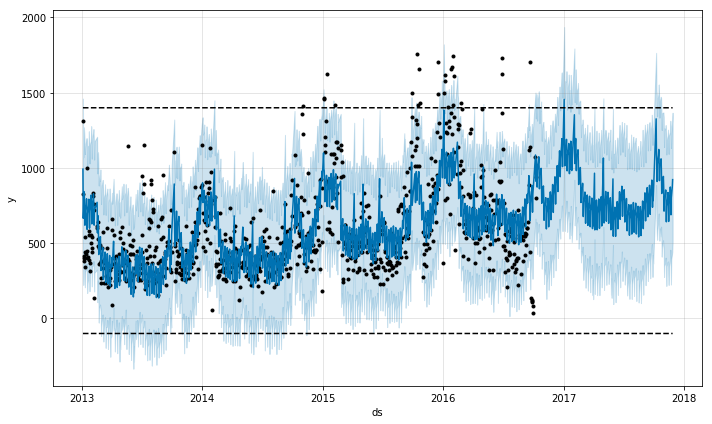

In [11]:
print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_workday.ds < '2016-01-10') & (forcast_brand9_workday.ds > '2016-01-01')])
m_brand9_workday.plot(forcast_brand9_workday)

In [12]:
brand9_result = pd.concat([forcast_brand9_workday, forcast_brand9_restday])
brand9_result = brand9_result.sort_values(by='ds', ascending=True)
print(brand9_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower   yhat_upper
302  2017-08-13   26.105568 -101.669503   155.793573
1151 2017-08-14  705.995982  260.959734  1128.955610
1152 2017-08-15  745.115028  318.590465  1145.070135
1153 2017-08-16  681.921338  296.735344  1130.873659
1154 2017-08-17  541.878555  105.705009   990.291674
1155 2017-08-18  648.019388  169.836068  1074.626063
303  2017-08-19  133.313458    9.221439   270.955499
1156 2017-08-21  699.032938  267.872687  1119.171076
1157 2017-08-22  742.979729  319.453405  1179.228977
1158 2017-08-23  685.093281  266.037901  1134.100870
1159 2017-08-24  550.706888  101.422636  1012.998055
1160 2017-08-25  662.711667  242.643257  1072.953551
304  2017-08-26  153.183508   26.486798   288.240379
1161 2017-08-28  731.069406  277.020346  1163.313730
1162 2017-08-29  780.223662  354.263315  1253.254573
1163 2017-08-30  727.031029  298.599145  1152.964896
1164 2017-08-31  596.709168  157.581714  1009.808628
1165 2017-09-01  712.052436  282.306025  1131.

In [16]:
df_brand1_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand1_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand1_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property != 0)]
m_brand1_restday, forcast_brand1_restday = predictByProphet(df_brand1_restday, test_data_brand1_restday, holidays, 300, -50, 200, 0.5,
                0.95, df_brand1_restday_regressor_set, brand1_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
97  2016-01-03   29.611366  -31.406034   91.651647
98  2016-01-09  101.410925   36.534452  167.574562
99  2016-01-16   93.934076   25.445963  153.705873
100 2016-01-23   83.507654   17.956009  151.029585
101 2016-01-30   82.811107   16.810230  147.018599
102 2016-02-20  108.926472   41.433625  169.015428
103 2016-02-27   93.626574   34.165099  158.450725
104 2016-03-12   77.080037   13.864973  143.759377
105 2016-03-19   85.916102   17.978996  151.873459
106 2016-03-26   88.632041   23.944812  149.742637
107 2016-03-27   56.049864  -13.164538  124.102730
108 2016-04-09   60.582331   -4.319244  126.512473
109 2016-04-16   58.586999   -5.266678  126.657916
110 2016-05-07  107.798630   43.813424  171.794733
111 2016-05-14  100.696895   32.297577  165.263412
112 2016-05-21   86.966574   19.938322  153.114904
113 2016-05-28   77.329220   10.854320  143.092338
114 2016-06-04   73.494371    8.878879  135.443588
115 2016-06-18   76.920152    8

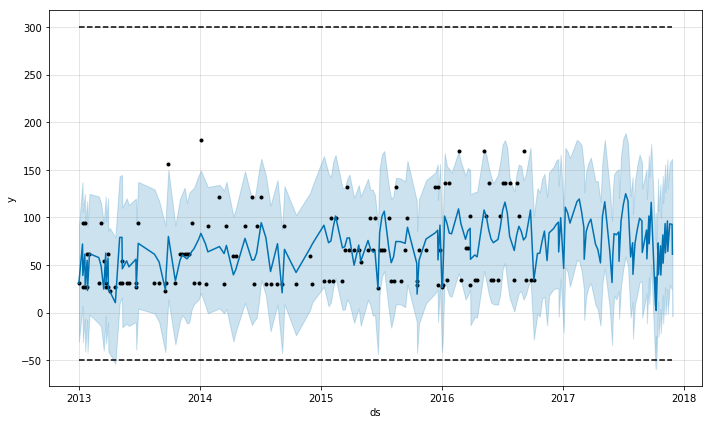

In [17]:
print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand1_restday.plot(forcast_brand1_restday)

In [18]:
df_brand1_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & (train_data.date_property == 0)]
df_brand1_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand1_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property == 0)]
m_brand1_workday, forcast_brand1_workday = predictByProphet(df_brand1_workday, test_data_brand1_workday, holidays, 1500, -50, 1500, 0.5,
                0.95, df_brand1_workday_regressor_set, brand1_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1123 2017-07-06  367.524145   86.579511  615.377511
1124 2017-07-07  399.492245  125.794929  677.947214
1125 2017-07-10  471.907679  206.310932  721.621552
1126 2017-07-11  462.550844  166.526741  720.934249
1127 2017-07-12  413.215679  143.767934  688.851841
1128 2017-07-13  349.213622   99.559487  614.194574
1129 2017-07-14  376.825107  113.108876  642.273987
1130 2017-07-17  439.037562  161.264085  710.620698
1131 2017-07-18  427.469052  145.131947  693.993208
1132 2017-07-19  376.599658   98.931446  635.108565
1133 2017-07-20  311.767312   55.390692  560.436428
1134 2017-07-21  339.262417   64.922504  605.414642
1135 2017-07-24  405.260093  156.548890  676.973532
1136 2017-07-25  396.202613  150.119894  656.946713
1137 2017-07-26  348.368757   78.755248  620.103575
1138 2017-07-27  287.018292   19.873801  559.724948
1139 2017-07-28  318.354237   58.134120  571.029727
1140 2017-07-31  397.066299  125.130549  652.723394
1141 2017-08

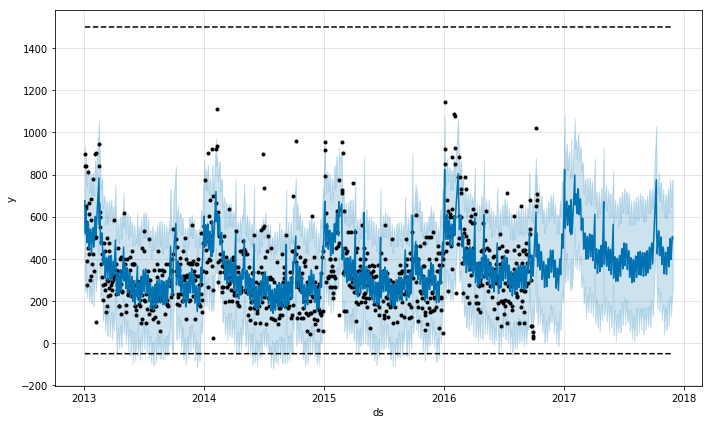

In [19]:
print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_workday.ds < '2016-01-10') & (forcast_brand1_workday.ds > '2016-01-01')])
m_brand1_workday.plot(forcast_brand1_workday)

In [20]:
brand1_result = pd.concat([forcast_brand1_workday, forcast_brand1_restday])
brand1_result = brand1_result.sort_values(by='ds', ascending=True)
print(brand1_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1148 2017-08-10  311.523394   33.727135  586.328119
1149 2017-08-11  346.744807   87.416109  602.784840
172  2017-08-12   87.225113   19.087817  154.680125
1150 2017-08-14  431.751327  169.182362  699.671081
1151 2017-08-15  427.306518  155.898728  698.054335
1152 2017-08-16  383.117770  136.603203  647.540216
1153 2017-08-17  324.420013   49.048510  584.904941
1154 2017-08-18  357.417172   97.986536  627.954889
173  2017-08-19   99.175422   31.903469  166.089728
1155 2017-08-21  435.535585  153.568885  711.663100
1156 2017-08-22  428.955646  165.095749  689.404020
1157 2017-08-23  382.815318  118.924740  656.290786
1158 2017-08-24  322.400056   64.063891  600.133624
1159 2017-08-25  353.955015  110.908772  627.605658
174  2017-08-26   96.268136   32.955507  158.057386
175  2017-08-27   63.157815   -5.107316  130.492271
1160 2017-08-28  429.656693  159.940884  699.727863
1161 2017-08-29  422.940727  165.282869  677.339502
1162 2017-08

In [25]:
df_brand2_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand2_restday_regressor_set = ['day_of_week_1', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand2_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property != 0)]
m_brand2_restday, forcast_brand2_restday = predictByProphet(df_brand2_restday, test_data_brand2_restday, holidays, 200, -100, 200, 0.5,
                0.95, df_brand2_restday_regressor_set, brand2_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
83  2015-10-07   40.781338  -28.236973  102.353415
84  2015-10-31   36.777417  -27.845871   97.467689
85  2015-11-21   55.730378   -9.961741  115.623010
86  2015-11-28   66.722507    5.643725  128.642844
87  2015-12-05   67.218808    4.619935  130.723852
88  2015-12-19   74.744351   15.693180  135.437212
89  2015-12-26   91.927392   29.874406  153.567586
90  2016-01-02   57.422010   -6.099080  117.155206
91  2016-01-03   41.595379  -22.135261  108.286015
92  2016-01-09  117.779438   51.702435  183.541993
93  2016-01-23  107.633933   44.724985  170.020253
94  2016-01-30   93.645562   35.181454  157.354461
95  2016-02-20   65.157827    4.708410  126.342438
96  2016-02-27   71.371137   11.745296  134.924372
97  2016-03-05   77.967604   16.771398  138.832868
98  2016-03-12   78.516451   13.075960  141.868109
99  2016-03-19   73.933045   12.603832  136.743905
100 2016-03-26   69.320743    1.740235  131.525597
101 2016-04-02   42.326883  -22

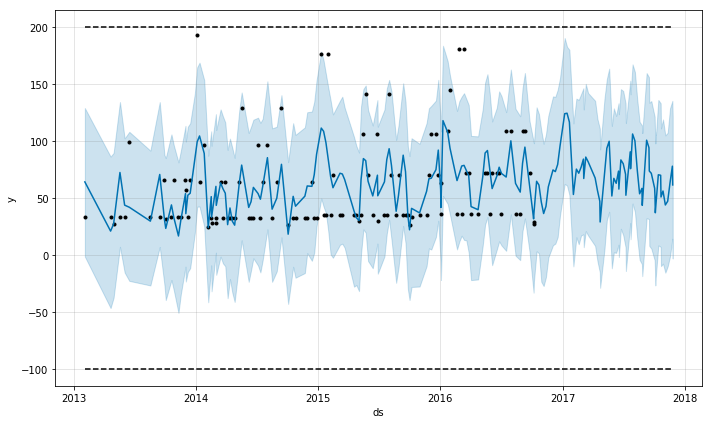

In [26]:
print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand2_restday.plot(forcast_brand2_restday)

In [27]:
df_brand2_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & (train_data.date_property == 0)]
df_brand2_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand2_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property == 0)]
m_brand2_workday, forcast_brand2_workday = predictByProphet(df_brand2_workday, test_data_brand2_workday, holidays, 1500, -200, 800, 0.5,
                0.95, df_brand2_workday_regressor_set, brand2_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1123 2017-07-06  191.988108  -12.927101  404.643388
1124 2017-07-07  226.404753    2.490689  446.280121
1125 2017-07-10  255.577424   33.180275  447.282841
1126 2017-07-11  292.349069   59.398389  498.726761
1127 2017-07-12  262.374081   49.271623  477.901671
1128 2017-07-13  197.293431   -3.481869  413.027397
1129 2017-07-14  232.436346   30.499677  446.682241
1130 2017-07-17  263.961762   61.386551  468.031396
1131 2017-07-18  301.553583   92.283291  504.467820
1132 2017-07-19  272.403905   51.651366  475.095424
1133 2017-07-20  208.144726    4.984247  412.767431
1134 2017-07-21  244.095355   32.652572  460.692977
1135 2017-07-24  277.847635   64.685180  481.256870
1136 2017-07-25  316.073854  100.569884  545.024982
1137 2017-07-26  287.481506   63.950782  503.819184
1138 2017-07-27  223.687973   23.108482  436.988161
1139 2017-07-28  259.997811   50.481521  476.030285
1140 2017-07-31  294.046757   80.273816  509.351079
1141 2017-08

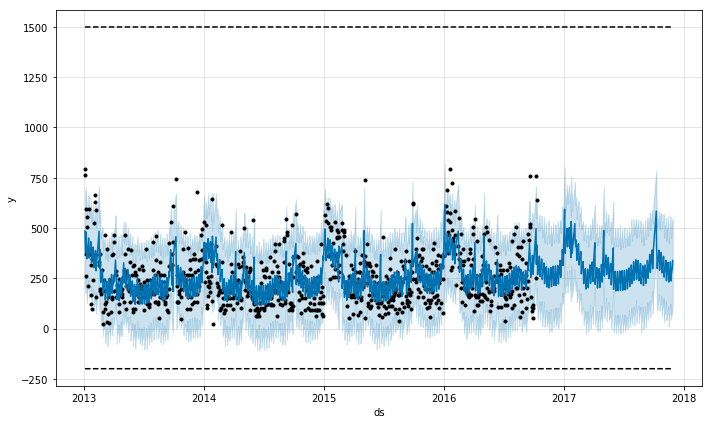

In [28]:
print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_workday.ds < '2016-01-10') & (forcast_brand2_workday.ds > '2016-01-01')])
m_brand2_workday.plot(forcast_brand2_workday)

In [29]:
brand2_result = pd.concat([forcast_brand2_workday, forcast_brand2_restday])
brand2_result = brand2_result.sort_values(by='ds', ascending=True)
print(brand2_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1145 2017-08-07  305.100894   89.429101  524.905666
1146 2017-08-08  341.684118  140.050734  548.295819
1147 2017-08-09  311.126714   86.153638  529.342843
1148 2017-08-10  245.056219   26.021008  450.945930
1149 2017-08-11  278.794032   72.124184  487.765193
161  2017-08-12   74.406209   14.173990  136.148359
1150 2017-08-14  303.627978  102.173546  516.491599
1151 2017-08-15  338.202688  114.934770  542.301568
1152 2017-08-16  305.679518  101.211484  519.206124
1153 2017-08-17  237.723261   27.944380  458.747540
1154 2017-08-18  269.692934   54.588953  470.190156
162  2017-08-19   53.567590   -4.320231  116.755454
1155 2017-08-21  290.292297   90.163848  498.641615
1156 2017-08-22  323.923447  108.197476  536.057709
1157 2017-08-23  290.738437   77.625701  504.676467
1158 2017-08-24  222.424289  -19.345520  431.131260
1159 2017-08-25  254.357022   27.831614  468.671695
163  2017-08-26   58.318220   -8.226524  113.622436
164  2017-08

In [48]:
df_brand3_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand3_restday_regressor_set = ['day_of_week_4', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand3_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property != 0)]
m_brand3_restday, forcast_brand3_restday = predictByProphet(df_brand3_restday, test_data_brand3_restday, holidays, 120, -100, 150, 0.5,
                0.95, df_brand3_restday_regressor_set, brand3_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
86  2015-12-05   55.736421   11.112901  102.723239
87  2015-12-12   56.016048    9.702601  103.554858
88  2015-12-19   68.164243   20.916218  112.971549
89  2015-12-26   84.999546   36.420767  133.118664
90  2016-01-09  104.332430   57.981991  149.956240
91  2016-01-16  109.438914   64.306911  158.316172
92  2016-01-23  114.466647   68.711460  160.433361
93  2016-01-30  113.645079   71.121821  160.204453
94  2016-02-20   65.694229   18.783650  111.916487
95  2016-02-27   65.881522   16.273100  112.859349
96  2016-03-05   76.592663   30.178326  125.110599
97  2016-03-12   83.430926   36.125486  133.745843
98  2016-03-19   77.382953   26.968760  123.651532
99  2016-03-26   63.656509   15.241750  113.690984
100 2016-04-02   69.607512   23.303596  117.553052
101 2016-04-09   56.710353   12.999828  100.950035
102 2016-04-16   64.957787   17.581300  111.489091
103 2016-04-23   72.402107   20.701324  115.641129
104 2016-05-07   86.153851   38

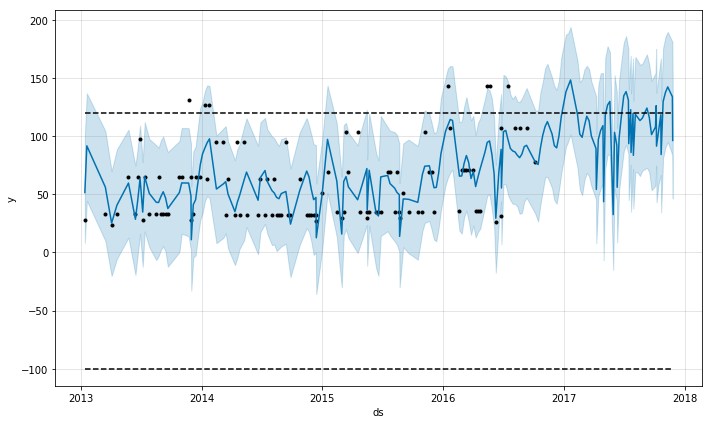

In [49]:
print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_restday.ds < '2016-01-10') & (forcast_brand3_restday.ds > '2016-01-01')])
m_brand3_restday.plot(forcast_brand3_restday)

In [50]:
df_brand3_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & (train_data.date_property == 0)]
df_brand3_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand3_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property == 0)]
m_brand3_workday, forcast_brand3_workday = predictByProphet(df_brand3_workday, test_data_brand3_workday, holidays, 1500, -100, 1000, 0.5,
                0.95, df_brand3_workday_regressor_set, brand3_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1123 2017-07-06  146.789350  -72.679466  377.707890
1124 2017-07-07  190.723625  -48.127617  431.044048
1125 2017-07-10  246.845838   32.442369  477.177871
1126 2017-07-11  254.006681   20.554619  509.822197
1127 2017-07-12  212.678968  -11.051892  439.769728
1128 2017-07-13  151.325697  -74.450943  383.893936
1129 2017-07-14  194.053716  -33.520659  425.608437
1130 2017-07-17  246.062532   14.801657  489.805195
1131 2017-07-18  251.791451   17.684222  481.582676
1132 2017-07-19  209.057848  -21.919882  461.464486
1133 2017-07-20  146.359346  -74.500560  396.200611
1134 2017-07-21  187.836612  -53.964589  429.192641
1135 2017-07-24  236.966887   10.683332  454.368198
1136 2017-07-25  242.113394    9.293574  458.825652
1137 2017-07-26  199.018050  -41.630623  461.673613
1138 2017-07-27  136.190021  -86.147714  382.304450
1139 2017-07-28  177.775780  -45.352348  415.696593
1140 2017-07-31  228.628453   17.124230  434.577387
1141 2017-08

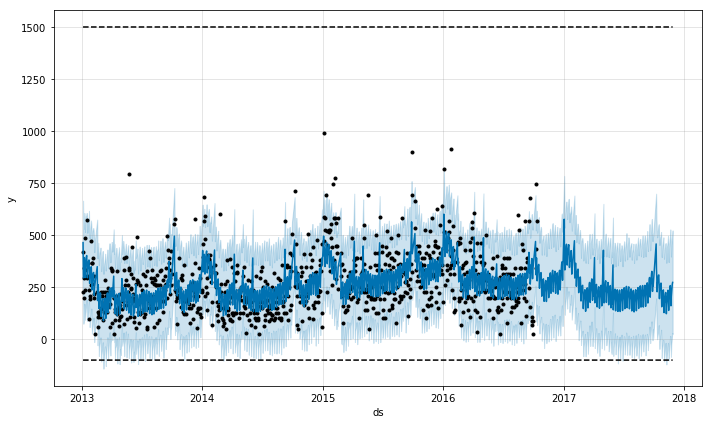

In [51]:
print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_workday.ds < '2016-01-10') & (forcast_brand3_workday.ds > '2016-01-01')])
m_brand3_workday.plot(forcast_brand3_workday)

In [52]:
brand3_result = pd.concat([forcast_brand3_workday, forcast_brand3_restday])
brand3_result = brand3_result.sort_values(by='ds', ascending=True)
print(brand3_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1141 2017-08-01  234.774996    2.450475  459.126662
1142 2017-08-02  192.859080  -27.987761  416.938913
1143 2017-08-03  131.362531  -90.860699  366.152147
1144 2017-08-04  174.400616  -45.676612  398.626331
168  2017-08-05  118.925258   69.298076  168.196667
1145 2017-08-07  229.982979  -15.792654  455.526706
1146 2017-08-08  237.706069   19.172162  460.560884
1147 2017-08-09  197.304653  -34.406700  413.985245
1148 2017-08-10  137.225492  -78.451834  382.363451
1149 2017-08-11  181.551576  -66.897313  413.641008
169  2017-08-12  116.269875   68.748802  165.077712
1150 2017-08-14  239.958294   13.636543  469.883519
1151 2017-08-15  248.213206   26.368367  488.604096
1152 2017-08-16  208.121419   -3.518295  454.437597
1153 2017-08-17  148.128430  -90.090057  402.569495
1154 2017-08-18  192.322211  -50.754908  433.547325
170  2017-08-19  113.523499   65.836496  161.583327
1155 2017-08-21  249.161036   19.054765  481.830825
1156 2017-08

In [53]:
brand3_result = pd.concat([forcast_brand3_workday, forcast_brand3_restday])
brand3_result = brand3_result.sort_values(by='ds', ascending=True)
print(brand3_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1141 2017-08-01  234.774996    2.450475  459.126662
1142 2017-08-02  192.859080  -27.987761  416.938913
1143 2017-08-03  131.362531  -90.860699  366.152147
1144 2017-08-04  174.400616  -45.676612  398.626331
168  2017-08-05  118.925258   69.298076  168.196667
1145 2017-08-07  229.982979  -15.792654  455.526706
1146 2017-08-08  237.706069   19.172162  460.560884
1147 2017-08-09  197.304653  -34.406700  413.985245
1148 2017-08-10  137.225492  -78.451834  382.363451
1149 2017-08-11  181.551576  -66.897313  413.641008
169  2017-08-12  116.269875   68.748802  165.077712
1150 2017-08-14  239.958294   13.636543  469.883519
1151 2017-08-15  248.213206   26.368367  488.604096
1152 2017-08-16  208.121419   -3.518295  454.437597
1153 2017-08-17  148.128430  -90.090057  402.569495
1154 2017-08-18  192.322211  -50.754908  433.547325
170  2017-08-19  113.523499   65.836496  161.583327
1155 2017-08-21  249.161036   19.054765  481.830825
1156 2017-08

In [55]:
df_brand4_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand4_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand4_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property != 0)]
m_brand4_restday, forcast_brand4_restday = predictByProphet(df_brand4_restday, test_data_brand4_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand4_restday_regressor_set, brand4_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
144 2016-05-07   77.762009   21.487071  134.787891
145 2016-05-14   90.750182   32.103706  148.796692
146 2016-05-21  105.454846   47.835995  162.447000
147 2016-05-28  112.043564   53.439208  167.837647
148 2016-06-04  105.032432   42.453726  164.709708
149 2016-06-09   55.800033   -1.382983  109.620446
150 2016-06-18   79.379039   26.457634  136.046750
151 2016-06-25   79.837030   23.555381  138.392524
152 2016-07-02   87.895479   27.795905  144.083091
153 2016-07-09   94.895849   35.575109  152.332280
154 2016-07-16   96.041644   39.139668  154.001103
155 2016-07-23   92.693398   36.659934  148.146984
156 2016-07-30   87.841149   28.965500  144.331838
157 2016-08-06   82.739153   30.329924  136.262413
158 2016-08-13   78.833900   24.745874  134.788364
159 2016-08-20   79.860791   22.557004  135.273248
160 2016-08-27   88.261076   31.512362  144.092862
161 2016-09-03   99.421856   39.673682  160.283239
162 2016-09-10  103.087846   44

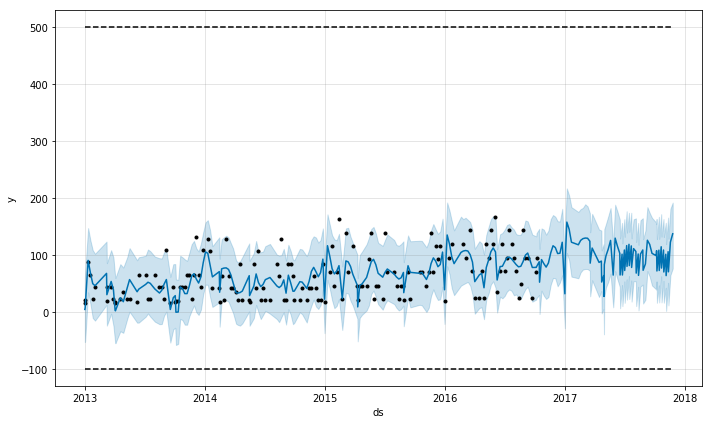

In [56]:
print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_restday.ds < '2016-01-10') & (forcast_brand4_restday.ds > '2016-01-01')])
m_brand4_restday.plot(forcast_brand4_restday)

In [57]:
df_brand4_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & (train_data.date_property == 0)]
df_brand4_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand4_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property == 0)]
m_brand4_workday, forcast_brand4_workday = predictByProphet(df_brand4_workday, test_data_brand4_workday, holidays, 1500, -200, 1300, 0.5,
                0.95, df_brand4_workday_regressor_set, brand4_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  275.674559   15.802516  544.326005
1125 2017-07-07  326.387982   71.473903  605.218339
1126 2017-07-10  439.301898  158.464733  690.022590
1127 2017-07-11  489.449098  203.900673  758.719775
1128 2017-07-12  387.970192  128.268167  665.240556
1129 2017-07-13  262.263417   -9.983376  515.339181
1130 2017-07-14  312.216013   41.723474  573.198194
1131 2017-07-17  423.865377  143.245953  691.473491
1132 2017-07-18  473.977985  213.734832  745.851361
1133 2017-07-19  372.669527   93.419831  657.384054
1134 2017-07-20  247.337163  -35.536328  507.237226
1135 2017-07-21  297.861600   33.941317  557.590171
1136 2017-07-24  412.268820  131.673138  697.263972
1137 2017-07-25  463.578487  189.562552  764.950541
1138 2017-07-26  363.562437   98.992918  647.572750
1139 2017-07-27  239.588304  -33.196274  536.224639
1140 2017-07-28  291.506371    9.193555  562.045914
1141 2017-07-31  410.011189  134.397461  683.873300
1142 2017-08

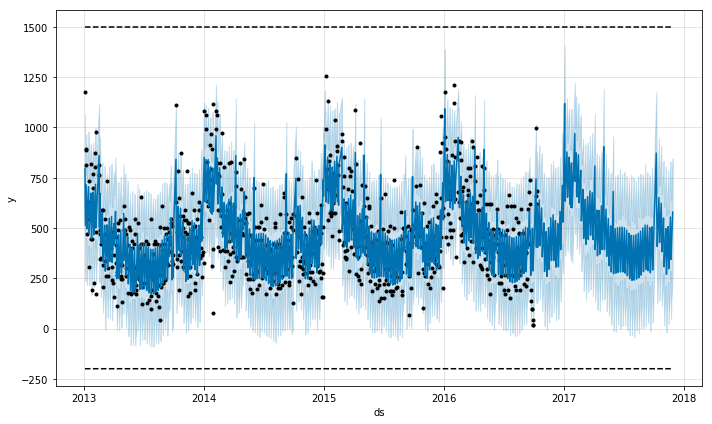

In [58]:
print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_workday.ds < '2016-01-10') & (forcast_brand4_workday.ds > '2016-01-01')])
m_brand4_workday.plot(forcast_brand4_workday)

In [59]:
brand4_result = pd.concat([forcast_brand4_workday, forcast_brand4_restday])
brand4_result = brand4_result.sort_values(by='ds', ascending=True)
print(brand4_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1149 2017-08-10  246.024769   -9.512479  497.506414
1150 2017-08-11  299.101725   27.002689  582.061053
219  2017-08-12  101.452357   43.856682  155.887443
220  2017-08-13   63.864299    2.305706  117.526055
1151 2017-08-14  420.274716  150.613281  698.192989
1152 2017-08-15  473.552218  219.526959  757.788431
1153 2017-08-16  375.380971  120.638549  635.338536
1154 2017-08-17  253.148497  -24.157094  555.205441
1155 2017-08-18  306.728213   37.844266  587.558283
221  2017-08-19  101.298604   44.354954  160.633511
1156 2017-08-21  429.986027  168.741984  713.704703
1157 2017-08-22  484.129205  222.523936  770.164639
1158 2017-08-23  386.882289  104.157154  648.581668
1159 2017-08-24  265.607689   -0.174000  548.114190
1160 2017-08-25  320.148476   69.439459  587.748859
222  2017-08-26  108.477979   47.627950  164.196457
223  2017-08-27   72.820557   14.445735  127.352766
1161 2017-08-28  445.947613  156.729068  733.492844
1162 2017-08

In [61]:
df_brand6_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand6_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand6_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property != 0)]
m_brand6_restday, forcast_brand6_restday = predictByProphet(df_brand6_restday, test_data_brand6_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand6_restday_regressor_set, brand6_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
210 2016-08-13  69.640546   26.967159  109.015767
211 2016-08-20  67.447871   25.270699  109.727088
212 2016-08-27  62.679435   21.062119  104.568896
213 2016-08-28  30.370609  -13.527959   72.519782
214 2016-09-03  60.739156   18.603059  100.355246
215 2016-09-10  62.079005   19.056476  104.775431
216 2016-09-17  24.482594  -18.124830   66.978386
217 2016-09-24  58.119241   18.984153   98.618141
218 2016-10-04  34.032270   -4.780628   75.086707
219 2016-10-05  31.571321   -9.697180   69.892074
220 2016-10-06  19.500221  -19.038323   61.794348
221 2016-10-07  13.126213  -27.839271   54.554115
222 2016-10-15  53.202129   15.227658   91.484772
223 2016-10-22  57.602917   15.718755   95.730710
224 2016-10-29  58.638980   18.822187   98.601142
225 2016-10-30  26.673164  -13.324467   66.506857
226 2016-11-05  56.386572   11.866151   99.145411
227 2016-11-12  54.476602   13.396327   93.355767
228 2016-11-19  54.463418   15.429041   90.837328


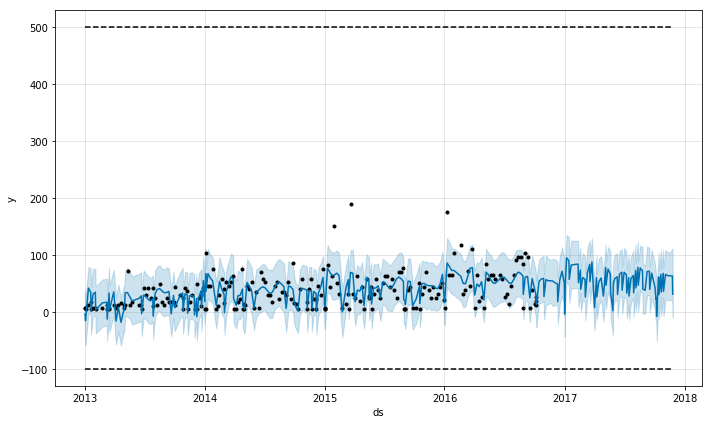

In [62]:
print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_restday.ds < '2016-01-10') & (forcast_brand6_restday.ds > '2016-01-01')])
m_brand6_restday.plot(forcast_brand6_restday)

In [63]:
df_brand6_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & (train_data.date_property == 0)]
df_brand6_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand6_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property == 0)]
m_brand6_workday, forcast_brand6_workday = predictByProphet(df_brand6_workday, test_data_brand6_workday, holidays, 1000, -200, 700, 0.5,
                0.95, df_brand6_workday_regressor_set, brand6_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  250.854350   97.513058  398.121295
1125 2017-07-07  288.281692  138.507517  434.620306
1126 2017-07-10  295.111846  151.974009  435.778167
1127 2017-07-11  324.515044  175.563861  480.173836
1128 2017-07-12  297.612449  150.144797  450.406667
1129 2017-07-13  249.300765   98.183309  404.777608
1130 2017-07-14  286.986659  134.438510  436.713862
1131 2017-07-17  295.382287  155.909800  439.658654
1132 2017-07-18  325.538108  174.865723  479.013428
1133 2017-07-19  299.478873  153.678576  456.628433
1134 2017-07-20  252.082115  105.863876  403.455836
1135 2017-07-21  290.733026  131.458136  424.329591
1136 2017-07-24  302.086653  160.851953  440.442625
1137 2017-07-25  333.166978  170.369335  485.863667
1138 2017-07-26  307.960918  173.611858  443.826804
1139 2017-07-27  261.323443  118.221331  411.353817
1140 2017-07-28  300.619258  144.456423  455.576987
1141 2017-07-31  313.059359  157.189465  455.459410
1142 2017-08

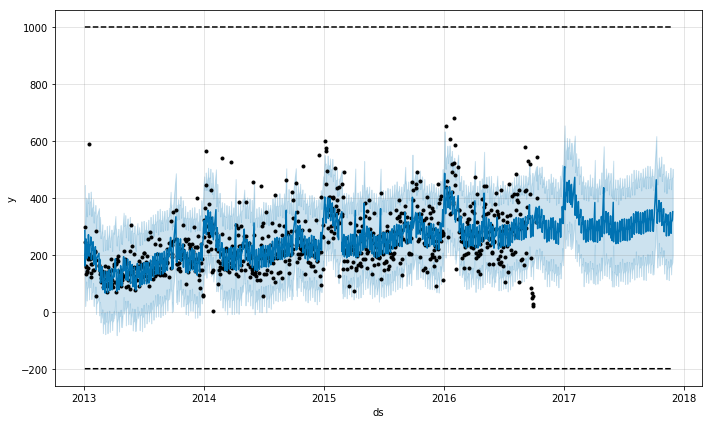

In [64]:
print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_workday.ds < '2016-01-10') & (forcast_brand6_workday.ds > '2016-01-01')])
m_brand6_workday.plot(forcast_brand6_workday)

In [65]:
brand6_result = pd.concat([forcast_brand6_workday, forcast_brand6_restday])
brand6_result = brand6_result.sort_values(by='ds', ascending=True)
print(brand6_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1150 2017-08-11  314.517333  160.295382  451.822405
284  2017-08-12   78.074897   37.211512  123.690336
285  2017-08-13   46.542547   -0.128520   88.084133
1151 2017-08-14  321.549675  173.652563  474.767758
1152 2017-08-15  350.774311  197.711097  495.712841
1153 2017-08-16  323.571956  176.392639  475.855008
1154 2017-08-17  274.843526  122.993697  438.372751
1155 2017-08-18  312.001844  153.997741  461.443791
286  2017-08-19   76.921869   38.125781  116.338470
1156 2017-08-21  318.236587  156.604515  472.448775
1157 2017-08-22  347.515175  192.441804  488.799152
1158 2017-08-23  320.520633  181.213180  470.836628
1159 2017-08-24  272.143648  125.556280  425.918995
1160 2017-08-25  309.782766  160.883482  458.843570
287  2017-08-26   72.155582   31.164830  113.312546
288  2017-08-27   39.764082   -3.732319   84.716667
1161 2017-08-28  318.042443  169.182646  477.457796
1162 2017-08-29  348.112863  199.364948  502.690493
1163 2017-08

In [67]:
df_brand7_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand7_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand7_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property != 0)]
m_brand7_restday, forcast_brand7_restday = predictByProphet(df_brand7_restday, test_data_brand7_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand7_restday_regressor_set, brand7_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
108 2015-12-26   77.386107    9.219114  144.723757
109 2016-01-01   34.823416  -33.086203  106.168314
110 2016-01-02   37.448326  -30.571749  105.374214
111 2016-01-09  119.846233   48.553825  193.621975
112 2016-01-16  101.873395   33.151349  171.669546
113 2016-01-23   75.312862    3.722717  144.948722
114 2016-01-30   70.444772    0.908559  140.786798
115 2016-02-20  104.643616   35.714019  168.089213
116 2016-02-27   77.979271    5.670199  145.832825
117 2016-03-12   73.450722    4.540045  139.868272
118 2016-03-26  118.891040   49.089256  190.022867
119 2016-04-02   56.385433  -11.700020  124.487480
120 2016-04-09   96.102590   23.225183  165.295626
121 2016-04-16   93.285757   19.333872  165.793848
122 2016-04-23  104.094994   35.896411  173.965523
123 2016-04-30   34.726177  -34.671169  102.623016
124 2016-05-07  103.769433   34.208754  177.031463
125 2016-05-14   90.938773   19.723542  159.309907
126 2016-05-21   90.093866   25

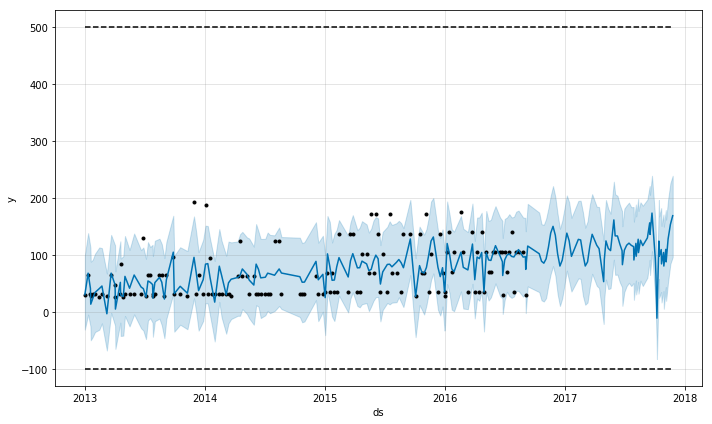

In [68]:
print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_restday.ds < '2016-01-10') & (forcast_brand7_restday.ds > '2016-01-01')])
m_brand7_restday.plot(forcast_brand7_restday)

In [69]:
df_brand7_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & (train_data.date_property == 0)]
df_brand7_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand7_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property == 0)]
m_brand7_workday, forcast_brand7_workday = predictByProphet(df_brand7_workday, test_data_brand7_workday, holidays, 1000, -200, 750, 0.5,
                0.95, df_brand7_workday_regressor_set, brand7_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1121 2017-07-06  303.595094   79.545207  517.459727
1122 2017-07-07  345.710165  122.954453  577.815675
1123 2017-07-10  354.227837  145.810106  582.966003
1124 2017-07-11  396.676936  188.382696  623.721955
1125 2017-07-12  359.381938  126.566721  590.299819
1126 2017-07-13  308.799230   81.950603  542.404232
1127 2017-07-14  349.572277  126.314440  582.164135
1128 2017-07-17  353.465305  129.828625  574.673133
1129 2017-07-18  394.290314  175.776744  602.109434
1130 2017-07-19  355.391121  123.883098  593.352093
1131 2017-07-20  303.260737   81.297402  524.682837
1132 2017-07-21  342.578099  141.295054  545.009323
1133 2017-07-24  342.978190  116.514079  568.821279
1134 2017-07-25  383.022287  163.985873  606.178402
1135 2017-07-26  343.570339  104.472099  577.803386
1136 2017-07-27  291.130626   74.946867  532.296468
1137 2017-07-28  330.392570   92.221393  554.937535
1138 2017-07-31  332.180837  107.886630  558.408320
1139 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


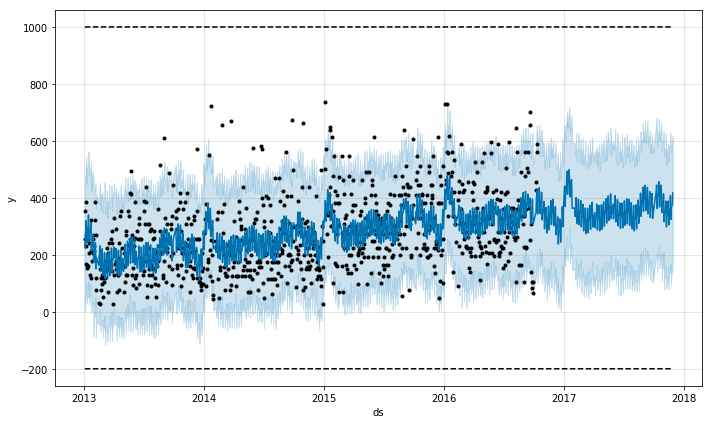

In [70]:
print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_workday.ds < '2016-01-10') & (forcast_brand7_workday.ds > '2016-01-01')])
m_brand7_workday.plot(forcast_brand7_workday)

In [71]:
brand7_result = pd.concat([forcast_brand7_workday, forcast_brand7_restday])
brand7_result = brand7_result.sort_values(by='ds', ascending=True)
print(brand7_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1144 2017-08-08  375.463840  146.079183  606.548873
1145 2017-08-09  339.389819  111.041870  561.587187
1146 2017-08-10  290.564679   69.278442  514.112400
1147 2017-08-11  333.624840  100.512303  562.931763
185  2017-08-12  127.324837   52.496365  198.190295
186  2017-08-13  103.945462   31.804621  177.010291
1148 2017-08-14  347.347005  114.626975  563.578884
1149 2017-08-15  392.324082  167.506842  608.191229
1150 2017-08-16  357.938133  146.565349  590.599373
1151 2017-08-17  310.625801   71.760588  529.186088
1152 2017-08-18  355.003993  126.483662  574.923810
187  2017-08-19  125.538984   54.481651  192.139502
1153 2017-08-21  371.359617  142.031935  593.760799
1154 2017-08-22  416.738641  207.558111  633.161638
1155 2017-08-23  382.506488  153.443848  607.984267
1156 2017-08-24  335.098221  111.166302  561.088684
1157 2017-08-25  379.132138  135.029470  593.588499
188  2017-08-26  116.166236   45.215852  186.141499
1158 2017-08

In [78]:
df_brand8_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand8_restday_regressor_set = ['day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isPureWeekend']
brand8_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property != 0)]
m_brand8_restday, forcast_brand8_restday = predictByProphet(df_brand8_restday, test_data_brand8_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand8_restday_regressor_set, brand8_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
39  2016-01-01   58.882384    5.652600  111.334813
40  2016-01-09   78.612359   24.866051  134.097170
41  2016-01-16  102.735474   52.045957  155.360145
42  2016-01-23  116.104197   64.853628  171.668953
43  2016-01-30  103.180171   53.034841  159.761690
44  2016-02-10   31.910726  -19.322850   81.659045
45  2016-02-20   78.135212   30.949445  133.680426
46  2016-02-27  101.144127   47.483339  152.215832
47  2016-03-05  115.292265   64.990494  167.548403
48  2016-03-12  110.026237   57.496502  167.952662
49  2016-03-19   86.234952   32.384130  136.473501
50  2016-03-26   50.888063   -2.181517  103.254208
51  2016-04-09    3.824408  -45.926579   57.706672
52  2016-04-16   28.379976  -22.293655   86.675126
53  2016-04-23   83.569571   32.568375  137.601135
54  2016-05-07  139.921353   86.421405  190.173540
55  2016-05-14   96.233992   46.387604  145.604346
56  2016-05-21   40.381155   -7.902401   93.443441
57  2016-05-28   20.501877  -33

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


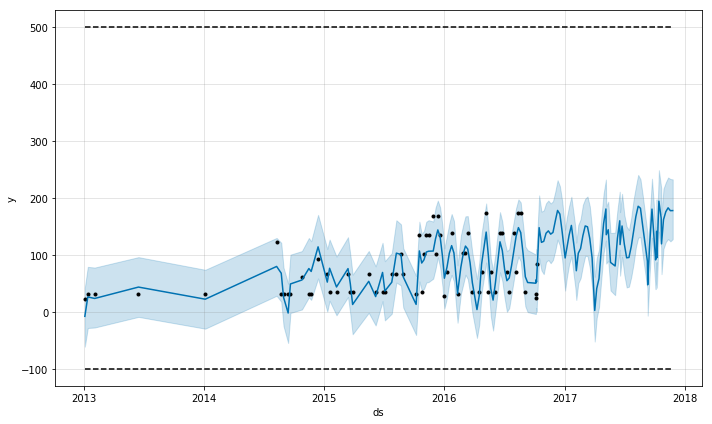

In [79]:
print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_restday.ds < '2016-01-10') & (forcast_brand8_restday.ds > '2016-01-01')])
m_brand8_restday.plot(forcast_brand8_restday)

In [80]:
df_brand8_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & (train_data.date_property == 0)]
df_brand8_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand8_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property == 0)]
m_brand8_workday, forcast_brand8_workday = predictByProphet(df_brand8_workday, test_data_brand8_workday, holidays, 800, -300, 800, 0.5,
                0.95, df_brand8_workday_regressor_set, brand8_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
949  2017-07-06  407.446704  199.522245  617.055612
950  2017-07-07  438.148999  231.941910  654.055712
951  2017-07-10  511.072156  298.237803  750.172671
952  2017-07-11  529.343824  322.895055  741.285785
953  2017-07-12  498.436975  281.410001  704.971166
954  2017-07-13  449.939744  223.689757  658.568480
955  2017-07-14  480.210668  263.458548  701.296330
956  2017-07-17  547.477999  338.469404  769.218341
957  2017-07-18  562.553514  329.385986  775.139361
958  2017-07-19  527.906188  313.464719  745.935942
959  2017-07-20  475.211414  276.893958  700.545001
960  2017-07-21  500.925918  282.293557  723.597303
961  2017-07-24  553.465012  340.329531  765.462878
962  2017-07-25  563.661400  352.933815  791.110155
963  2017-07-26  524.341078  308.050282  728.570081
964  2017-07-27  467.287685  258.060547  679.797265
965  2017-07-28  489.058176  259.942905  708.324242
966  2017-07-31  533.084832  312.848608  745.890420
967  2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


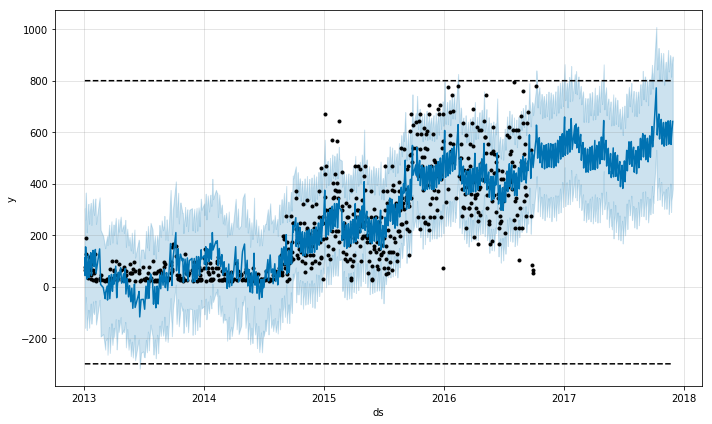

In [81]:
print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_workday.ds < '2016-01-10') & (forcast_brand8_workday.ds > '2016-01-01')])
m_brand8_workday.plot(forcast_brand8_workday)

In [82]:
brand8_result = pd.concat([forcast_brand8_workday, forcast_brand8_restday])
brand8_result = brand8_result.sort_values(by='ds', ascending=True)
print(brand8_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
970  2017-08-04  466.924556  253.018569  681.487136
118  2017-08-05  167.207084  113.124873  219.410056
971  2017-08-07  516.914440  304.551865  737.410238
972  2017-08-08  528.721503  305.984060  757.545389
973  2017-08-09  492.174464  255.795632  701.600739
974  2017-08-10  438.973239  225.077861  661.864580
975  2017-08-11  465.565107  259.799332  709.579176
119  2017-08-12  185.292489  130.039040  240.327383
976  2017-08-14  528.449992  307.716877  757.361229
977  2017-08-15  544.317545  328.160133  757.492271
978  2017-08-16  511.539039  290.043995  732.705215
979  2017-08-17  461.721704  238.302199  675.215434
980  2017-08-18  491.230902  259.626390  719.950885
120  2017-08-19  181.755771  130.986243  232.658068
981  2017-08-21  559.451105  334.231562  782.616567
982  2017-08-22  575.829767  340.744014  786.571514
983  2017-08-23  542.906278  319.265028  752.441266
984  2017-08-24  492.300153  274.091626  705.068111
985  2017-08

In [87]:
df_brand10_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand10_restday_regressor_set = ['day_of_week_1', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand10_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property != 0)]
m_brand10_restday, forcast_brand10_restday = predictByProphet(df_brand10_restday, test_data_brand10_restday, holidays, 200, -100, 180, 0.5,
                0.95, df_brand10_restday_regressor_set, brand10_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
146 2016-02-27   47.539806   -6.664321  102.465063
147 2016-03-12   59.378635    4.104678  109.953581
148 2016-03-19   68.208455   18.461459  117.623856
149 2016-03-26   63.732713   10.534757  113.492535
150 2016-04-02   42.487966   -9.725310   96.560543
151 2016-04-09   43.397665  -13.001146   96.408906
152 2016-04-16   47.119585   -7.115345   98.055978
153 2016-05-07   48.666349   -3.287664  106.163111
154 2016-05-14   43.414200  -11.576662   91.918871
155 2016-05-21   44.866178   -8.844751   96.055926
156 2016-06-04   46.734129   -4.767557  100.587576
157 2016-06-25   53.094826   -3.981936  105.433880
158 2016-07-02   69.468457   15.248204  120.284892
159 2016-07-09   78.047111   21.290695  128.250562
160 2016-07-23   65.158420    9.449700  118.051734
161 2016-07-30   60.105107    6.780213  112.463497
162 2016-08-06   59.797419    5.833215  111.574440
163 2016-08-13   59.069615    7.114367  113.291831
164 2016-08-20   57.601206    5

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


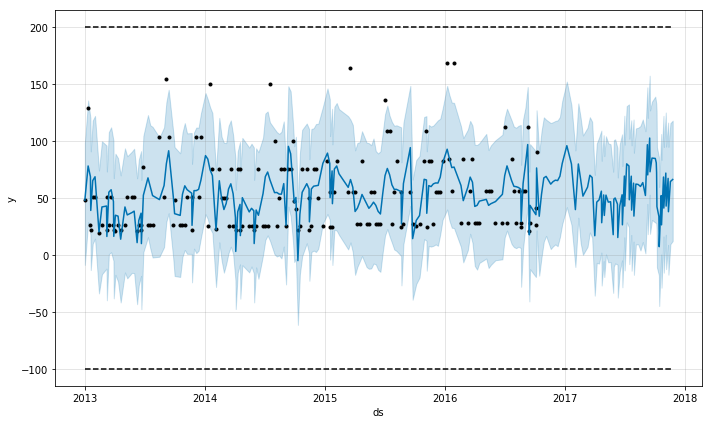

In [88]:
print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_restday.ds < '2016-01-10') & (forcast_brand10_restday.ds > '2016-01-01')])
m_brand10_restday.plot(forcast_brand10_restday)

In [89]:
df_brand10_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & (train_data.date_property == 0)]
df_brand10_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand10_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property == 0)]
m_brand10_workday, forcast_brand10_workday = predictByProphet(df_brand10_workday, test_data_brand10_workday, holidays, 2000, 1000, 2000, 0.5,
                0.95, df_brand10_workday_regressor_set, brand10_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  108.668839 -205.988199  471.278408
1125 2017-07-07  180.398740 -159.828471  525.237036
1126 2017-07-10  268.846477  -61.742075  617.383417
1127 2017-07-11  240.479490  -75.376781  567.681057
1128 2017-07-12  200.301781 -151.408751  545.139112
1129 2017-07-13  110.908961 -198.550043  459.165782
1130 2017-07-14  178.524570 -162.380618  528.313976
1131 2017-07-17  256.182709  -85.790847  562.638750
1132 2017-07-18  225.005585 -102.363998  556.945788
1133 2017-07-19  182.524514 -169.148587  538.987860
1134 2017-07-20   91.387299 -240.298552  433.773872
1135 2017-07-21  157.857111 -189.309627  482.309766
1136 2017-07-24  235.858545 -102.846400  585.777314
1137 2017-07-25  206.046729  -99.066986  544.018298
1138 2017-07-26  165.515468 -155.905501  487.735433
1139 2017-07-27   76.867162 -257.349954  403.647769
1140 2017-07-28  146.306919 -169.702028  477.170208
1141 2017-07-31  235.362904  -83.409099  590.882673
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


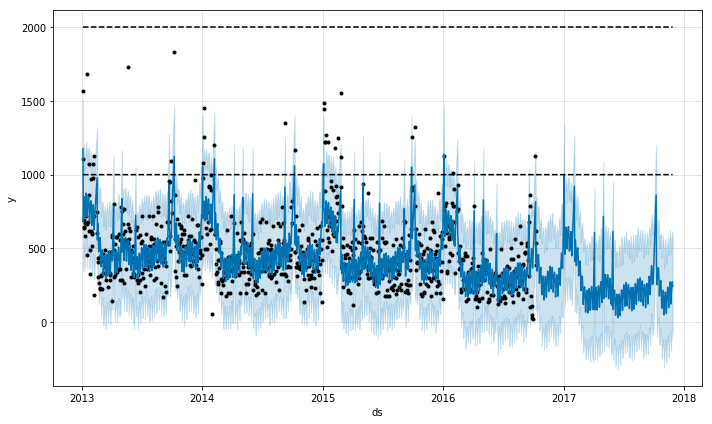

In [90]:
print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_workday.ds < '2016-01-10') & (forcast_brand10_workday.ds > '2016-01-01')])
m_brand10_workday.plot(forcast_brand10_workday)

In [91]:
brand10_result = pd.concat([forcast_brand10_workday, forcast_brand10_restday])
brand10_result = brand10_result.sort_values(by='ds', ascending=True)
print(brand10_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1149 2017-08-10  120.711517 -195.279481  447.281864
1150 2017-08-11  194.885165 -133.231057  535.356252
221  2017-08-12   61.740084    9.284631  111.524277
1151 2017-08-14  292.437610  -64.882601  643.008574
1152 2017-08-15  267.421492  -61.977870  633.294087
1153 2017-08-16  230.605262 -141.214571  550.420836
1154 2017-08-17  144.494401 -182.013903  486.059857
1155 2017-08-18  215.224042 -126.162951  531.596865
222  2017-08-19   60.003789    3.754632  113.108455
1156 2017-08-21  300.401074  -16.699189  627.935077
1157 2017-08-22  270.886861  -64.632006  582.935831
1158 2017-08-23  229.553395  -97.234679  563.310301
1159 2017-08-24  139.009991 -178.288399  481.937780
1160 2017-08-25  205.494807 -138.235888  540.263045
223  2017-08-26   63.394710   11.177159  118.812092
1161 2017-08-28  280.036246  -60.633530  628.822443
1162 2017-08-29  247.967202 -100.499672  588.129112
1163 2017-08-30  204.696345 -109.711686  529.109903
1164 2017-08

In [105]:
df_brand5_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand5_restday_regressor_set = ['day_of_week_2', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                                  'is_NationalDay', 
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand5_changepoints_restday = ['2014-10-01', '2015-10-01']
test_data_brand5_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property != 0)]
m_brand5_restday, forcast_brand5_restday = predictByProphet(df_brand5_restday, test_data_brand5_restday, holidays, 150, -300, 130, 0.5,
                0.95, df_brand5_restday_regressor_set, brand5_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
21  2015-11-07   95.607061   59.205322  131.524783
22  2015-11-14   64.616367   27.262356  102.881490
23  2015-11-21   59.864550   22.372527   97.526115
24  2015-11-28   72.754868   34.411767  109.545130
25  2015-12-05   76.957696   39.082180  116.562875
26  2015-12-12   68.766326   33.244713  106.093238
27  2015-12-19   71.980903   34.986279  107.763412
28  2015-12-26  102.049132   66.323718  138.270924
29  2016-01-09  143.148290  106.044937  180.425037
30  2016-01-16  107.404559   68.557431  144.876776
31  2016-01-30   53.280456   17.852441   91.406388
32  2016-02-20   90.679187   56.499981  129.753921
33  2016-02-27   63.604138   25.984467  101.881138
34  2016-03-05   52.512205   18.498051   89.202376
35  2016-03-12   72.636267   36.398096  110.043407
36  2016-03-19  101.026884   65.104325  140.364782
37  2016-03-26  104.278410   67.526508  140.407771
38  2016-04-02   36.999616    3.931168   74.281736
39  2016-04-09   45.763988    8

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


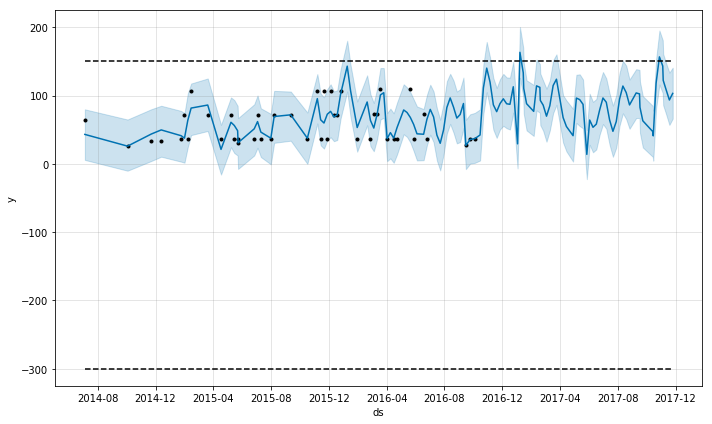

In [106]:
print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_restday.ds < '2016-01-10') & (forcast_brand5_restday.ds > '2016-01-01')])
m_brand5_restday.plot(forcast_brand5_restday)

In [107]:
df_brand5_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & (train_data.date_property == 0)]
df_brand5_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand5_changepoints_workday = ['2014-10-01', '2015-10-01']
test_data_brand5_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property == 0)]
m_brand5_workday, forcast_brand5_workday = predictByProphet(df_brand5_workday, test_data_brand5_workday, holidays, 1500, -100, 1500, 0.5,
                0.95, df_brand5_workday_regressor_set, brand5_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
702 2017-07-06  552.538878  270.294305   833.205880
703 2017-07-07  594.317828  319.693584   881.756964
704 2017-07-10  726.246441  438.095904  1031.028628
705 2017-07-11  712.283645  432.857979   980.925904
706 2017-07-12  664.172460  399.109254   951.558319
707 2017-07-13  590.405762  320.849324   848.056821
708 2017-07-14  626.795833  356.853545   900.396243
709 2017-07-17  740.289361  461.839877  1017.939084
710 2017-07-18  719.985145  461.146258   980.172546
711 2017-07-19  665.721363  396.753766   943.488285
712 2017-07-20  586.157241  296.483522   851.376547
713 2017-07-21  617.260918  351.186992   891.828125
714 2017-07-24  719.274698  474.692019   981.127325
715 2017-07-25  696.934998  424.964799   983.952166
716 2017-07-26  641.634221  376.628762   914.287879
717 2017-07-27  562.052050  306.102815   836.539285
718 2017-07-28  594.148532  310.863334   878.775631
719 2017-07-31  704.709496  439.652125   996.944089
720 2017-08-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


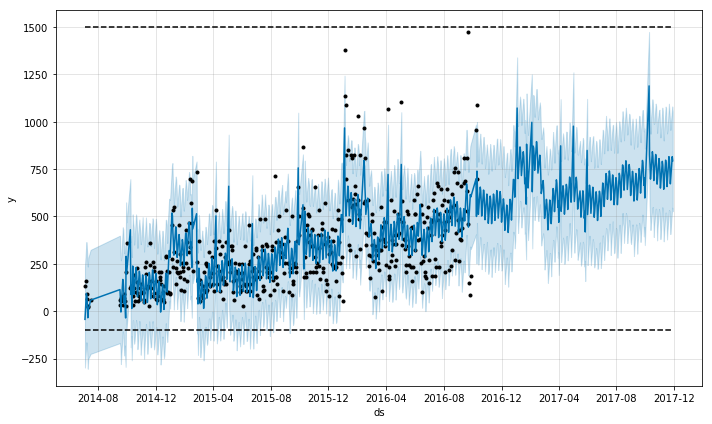

In [108]:
print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_workday.ds < '2016-01-10') & (forcast_brand5_workday.ds > '2016-01-01')])
m_brand5_workday.plot(forcast_brand5_workday)

In [109]:
brand5_result = pd.concat([forcast_brand5_workday, forcast_brand5_restday])
brand5_result = brand5_result.sort_values(by='ds', ascending=True)
print(brand5_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
719 2017-07-31  704.709496  439.652125   996.944089
720 2017-08-01  686.782572  432.448595   969.722460
721 2017-08-02  636.475582  342.786110   915.487527
722 2017-08-03  562.322010  282.064532   835.704602
723 2017-08-04  600.124181  322.441185   878.068171
104 2017-08-05   94.959829   56.132667   133.431064
724 2017-08-07  727.808652  454.635729  1002.424523
725 2017-08-08  715.045667  455.833595   982.432920
726 2017-08-09  669.376422  402.190318   955.624939
727 2017-08-10  599.201928  307.638276   895.697850
728 2017-08-11  640.210574  365.213371   931.403918
105 2017-08-12  114.042340   74.065145   150.769414
729 2017-08-14  772.076047  518.265282  1055.560229
730 2017-08-15  758.751881  464.937759  1029.964448
731 2017-08-16  711.539164  447.724362   990.634642
732 2017-08-17  638.875641  361.183850   901.587853
733 2017-08-18  676.511488  399.560349   967.256576
106 2017-08-19  104.423070   65.654819   144.031947
734 2017-08-

In [111]:
#将分品牌预测出来的结果合并
def fillPredictResult(df_test_data, df_fill_data, brand):
    df_test_data['predict_result'][df_test_data.brand == brand] = df_fill_data['yhat'].values
    return df_test_data

test_data['predict_result'] = 10
test_data = fillPredictResult(test_data, brand1_result[(brand1_result.ds < '2017-11-29') & (brand1_result.ds > '2016-10-11')], 1)
test_data = fillPredictResult(test_data, brand2_result[(brand2_result.ds < '2017-11-29') & (brand2_result.ds > '2016-10-11')], 2)
test_data = fillPredictResult(test_data, brand3_result[(brand3_result.ds < '2017-11-29') & (brand3_result.ds > '2016-10-11')], 3)
test_data = fillPredictResult(test_data, brand4_result[(brand4_result.ds < '2017-11-29') & (brand4_result.ds > '2016-10-11')], 4)
test_data = fillPredictResult(test_data, brand5_result[(brand5_result.ds < '2017-11-29') & (brand5_result.ds > '2016-10-11')], 5)
test_data = fillPredictResult(test_data, brand6_result[(brand6_result.ds < '2017-11-29') & (brand6_result.ds > '2016-10-11')], 6)
brand7_result = brand7_result.drop_duplicates(['ds'])
test_data = fillPredictResult(test_data, brand7_result[(brand7_result.ds < '2017-11-29') & (brand7_result.ds > '2016-10-11')], 7)
test_data = fillPredictResult(test_data, brand8_result[(brand8_result.ds < '2017-11-29') & (brand8_result.ds > '2016-10-11')], 8)
test_data = fillPredictResult(test_data, brand9_result[(brand9_result.ds < '2017-11-29') & (brand9_result.ds > '2016-10-11')], 9)
test_data = fillPredictResult(test_data, brand10_result[(brand10_result.ds < '2017-11-29') & (brand10_result.ds > '2016-10-11')], 10)
# print(len(test_data['predict_result'][test_data.brand == 7]))
# print(len(brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2016-05-04')]))
print(test_data[['ds', 'brand', 'day_of_week', 'date', 'predict_result']].head(100))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           ds  brand  day_of_week  date  predict_result
0  2016-10-12      1            3  1250      421.605588
1  2016-10-12      2            3  1250      335.200116
2  2016-10-12      3            3  1250      345.984800
3  2016-10-12      4            3  1250      520.946091
4  2016-10-12      5            3  1250      588.356866
5  2016-10-12      6            3  1250      338.471085
6  2016-10-12      7            3  1250      392.196759
7  2016-10-12      8            3  1250      554.563882
8  2016-10-12      9            3  1250     1004.961096
9  2016-10-12     10            3  1250      443.841065
10 2016-10-13      1            4  1251      362.800190
11 2016-10-13      2            4  1251      268.175564
12 2016-10-13      3            4  1251      280.671939
13 2016-10-13      4            4  1251      403.864614
14 2016-10-13      5            4  1251      511.372498
15 2016-10-13      6            4  1251      291.857271
16 2016-10-13      7            4  1251      343

In [112]:
test_data['predict_result'] = test_data['predict_result'].map(lambda x: x if x >= 5 else 10)
print(test_data[['date','brand', 'predict_result']][test_data.predict_result == 10].head(10))

      date  brand  predict_result
696   1327      6            10.0
697   1327      9            10.0
1441  1409      8            10.0
1442  1409      9            10.0
1904  1462      6            10.0
1905  1462      9            10.0
3056  1589      1            10.0
3059  1589      6            10.0
3060  1589      7            10.0
3062  1589      9            10.0


In [115]:
#将复赛B榜预测集的stacking数据导出
fusai_B_stacking_test_df = test_data[['date', 'brand', 'predict_result']]
fusai_B_stacking_test_df.to_csv('fusai_B_stacking_keng_test.csv', header=True, index=False)

In [121]:
#将训练集stacking出来的结果
train_data['predict_result'] = 10
train_data = fillPredictResult(train_data, brand1_result[(brand1_result.ds < '2016-10-12') & (brand1_result.ds > '2012-12-31')], 1)
train_data = fillPredictResult(train_data, brand2_result[(brand2_result.ds < '2016-10-12') & (brand2_result.ds > '2012-12-31')], 2)
train_data = fillPredictResult(train_data, brand3_result[(brand3_result.ds < '2016-10-12') & (brand3_result.ds > '2012-12-31')], 3)
train_data = fillPredictResult(train_data, brand4_result[(brand4_result.ds < '2016-10-12') & (brand4_result.ds > '2012-12-31')], 4)
train_data = fillPredictResult(train_data, brand5_result[(brand5_result.ds < '2016-10-12') & (brand5_result.ds > '2012-12-31')], 5)
train_data = fillPredictResult(train_data, brand6_result[(brand6_result.ds < '2016-10-12') & (brand6_result.ds > '2012-12-31')], 6)
# brand7_result = brand7_result.drop_duplicates(['ds'])
train_data = fillPredictResult(train_data, brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2012-12-31')], 7)
train_data = fillPredictResult(train_data, brand8_result[(brand8_result.ds < '2016-10-12') & (brand8_result.ds > '2012-12-31')], 8)
train_data = fillPredictResult(train_data, brand9_result[(brand9_result.ds < '2016-10-12') & (brand9_result.ds > '2012-12-31')], 9)
train_data = fillPredictResult(train_data, brand10_result[(brand10_result.ds < '2016-10-12') & (brand10_result.ds > '2012-12-31')], 10)

train_data['predict_result'] = train_data['predict_result'].map(lambda x: x if x >= 5 else 10)
print(train_data[['brand', 'date', 'y', 'ds', 'predict_result']].head(100))


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


    brand  date     y         ds  predict_result
0       1     1    31 2013-01-01       30.987790
1       6     1     6 2013-01-01       10.000000
2       9     1    15 2013-01-01       10.000000
3       4     2    20 2013-01-02       10.000000
4       6     2     6 2013-01-02       10.000000
5       7     2    30 2013-01-02       30.040764
6      10     2    48 2013-01-02       47.999189
7       4     3    16 2013-01-03        7.110931
8       6     3     4 2013-01-03       10.000000
9       8     3    23 2013-01-03       10.000000
10     10     4  1565 2013-01-04     1175.582912
11      9     4  1314 2013-01-04      992.067227
12      8     4    76 2013-01-04      110.922527
13      7     4   257 2013-01-04      240.147279
14      2     4   796 2013-01-04      485.106253
15      4     4  1411 2013-01-04      797.783754
16      3     4   418 2013-01-04      464.247880
17      1     4   898 2013-01-04      676.187011
18      6     4   299 2013-01-04      285.452345
19      8     5    6

In [122]:
#将复赛B榜训练集的stacking数据导出
fusai_B_stacking_train_df = train_data[['date', 'brand', 'predict_result']]
fusai_B_stacking_train_df.to_csv('fusai_B_stacking_keng_train.csv', header=True, index=False)